# Select a couple of simpler trips to compare

* Compare methodologies, which differ when handling more complex shapes
* But is it different even in simpler shapes?
* Start with Big Blue Bus and LA Metro

In [5]:
import geopandas as gpd
import pandas as pd
from siuba import *

from shared_utils import rt_dates, rt_utils
from segment_speed_utils import helpers
from segment_speed_utils.project_vars import SEGMENT_GCS, PROJECT_CRS

from prep_comparison import map_one_trip, remove_interpolated_segments

analysis_date = rt_dates.DATES["sep2023"]

import folium

In [6]:
from calitp_data_analysis.calitp_color_palette import CALITP_CATEGORY_BOLD_COLORS

In [15]:
df_eric = gpd.read_parquet(f"{SEGMENT_GCS}speeds_eric_{analysis_date}.parquet")
df_eric = remove_interpolated_segments(df_eric)
df_tiff = gpd.read_parquet(f"{SEGMENT_GCS}speeds_tiff_{analysis_date}.parquet")
speed_df = pd.read_parquet(
    f"{SEGMENT_GCS}speeds_comparison_{analysis_date}.parquet")

# Dataset-level comparison (pre-interpolation)

* drift is clear from histogram, but more analysis to come

In [16]:
#  interpolated segs successfully removed upstream!
speed_df.stop_sequence.unique()

array([  1.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
       101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.])

In [17]:
speed_df >> count(_._merge)

,_merge,n
0,left_only,8067
1,right_only,0
2,both,130920


In [18]:
speed_df = speed_df >> filter(_._merge == 'both')

In [19]:
speed_df >> head(10)

,trip_id,shape_id,stop_id,stop_sequence,route_id,direction_id,eric_speed_mph,tiff_speed_mph,_merge
10,58743406,804EB_RC_221121,80137,3.0,804,0.0,19.809278,19.569272,both
11,58743405,804EB_RC_221121,80137,3.0,804,0.0,20.583078,22.037468,both
12,58743402,804EB_RC_221121,80137,3.0,804,0.0,16.781108,17.472564,both
13,58743399,804EB_RC_221121,80137,3.0,804,0.0,25.091752,25.218134,both
14,58743400,804EB_RC_221121,80137,3.0,804,0.0,19.959348,14.345499,both
15,58743388,804EB_RC_221121,80137,3.0,804,0.0,20.423519,16.365992,both
16,58743398,804EB_RC_221121,80137,3.0,804,0.0,22.139781,22.037468,both
17,58743387,804EB_RC_221121,80137,3.0,804,0.0,21.247048,17.088021,both
18,58743386,804EB_RC_221121,80137,3.0,804,0.0,20.745149,10.757736,both
19,58743383,804EB_RC_221121,80137,3.0,804,0.0,21.077072,10.373532,both


In [22]:
speed_df >> filter(_.tiff_speed_mph > 80)

,trip_id,shape_id,stop_id,stop_sequence,route_id,direction_id,eric_speed_mph,tiff_speed_mph,_merge
4223,10070003020649-JUNE23,700302_JUNE23,5388,5.0,70-13168,0.0,10.074708,3057.887123,both
15752,10014005080546-JUNE23,140508_JUNE23,9001,10.0,14-13168,1.0,7.701576,100.665699,both
15872,10720012970644-JUNE23,7201297_JUNE23,16995,10.0,720-13168,1.0,12.255196,81.836541,both
17600,908191,26463,665,10.0,3637,0.0,19.816118,373.048041,both
18088,10014005080546-JUNE23,140508_JUNE23,9012,11.0,14-13168,1.0,4.466432,100.665699,both
19940,906696,26435,283,11.0,3629,0.0,24.416407,438.686864,both
20355,10070003020649-JUNE23,700302_JUNE23,5377,12.0,70-13168,0.0,9.897329,3510.590362,both
22150,10224002710644-JUNE23,2240271_JUNE23,14217,12.0,224-13168,1.0,31.067499,510.039395,both
22670,10070003020649-JUNE23,700302_JUNE23,11917,13.0,70-13168,0.0,9.894229,1885.223110,both
23172,10066004210649-JUNE23,660421_JUNE23,7422,13.0,66-13168,0.0,6.431943,330.852005,both


<AxesSubplot:>

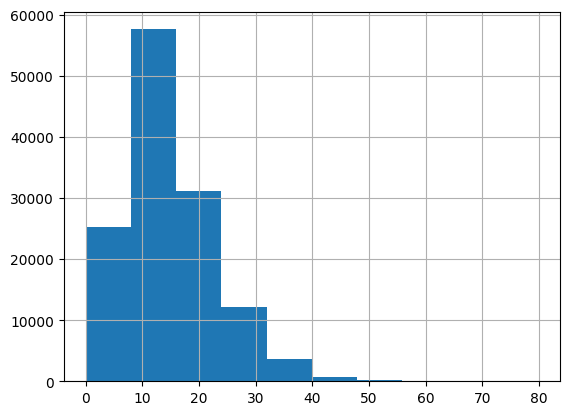

In [20]:
speed_df.eric_speed_mph.hist()

<AxesSubplot:>

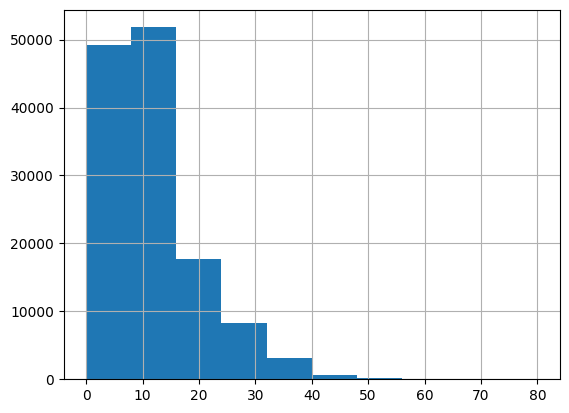

In [23]:
(speed_df >> filter(_.tiff_speed_mph < 80)).tiff_speed_mph.hist()

## Side-by-Side Maps

In [117]:
df_eric.shape, df_tiff.shape 

((151014, 23), (155314, 24))

In [118]:
#df_tiff.route_id.unique()

In [119]:
#one_route = "96-13168"
#df_tiff[df_tiff.route_id==one_route].explore(
#    "route_id", tiles = "CartoDB Positron")

In [120]:
#df_tiff[df_tiff.route_id==one_route].trip_id.unique()

In [121]:
trips_to_try = {
    "metro_720": "10720012750651-JUNE23", #route_id: 720-13168
    "metro_901": "10901000590843-JUNE23", #route_id: 901-13168
    "metro_550": "10550001350610-JUNE23", # route_id: 550-13168
    "metro_230":  "10230000830600-JUNE23", # route_id: 230-13168
    "metro_96": "10096002510743-JUNE23", # route_id: 96-13168
    "bbb1": "908521", # route_id: 3639
    #"bbb2": "", #route_id
}

In [122]:
# map_one_trip(df_eric, trips_to_try["metro_720"])

In [123]:
# map_one_trip(df_tiff, trips_to_try["metro_720"])

In [124]:
# map_one_trip(df_eric, trips_to_try["metro_901"])

In [125]:
# map_one_trip(df_tiff, trips_to_try["metro_901"])

In [126]:
# map_one_trip(df_eric, trips_to_try["metro_550"])

In [127]:
# map_one_trip(df_tiff, trips_to_try["metro_550"])

In [128]:
# map_one_trip(df_eric, trips_to_try["metro_230"])

In [129]:
# map_one_trip(df_tiff, trips_to_try["metro_230"])

In [130]:
map_one_trip(df_eric, trips_to_try["metro_96"])

In [131]:
map_one_trip(df_tiff, trips_to_try["metro_96"])

In [132]:
# map_one_trip(df_eric, trips_to_try["bbb1"])

In [133]:
# map_one_trip(df_tiff, trips_to_try["bbb1"])

# Dig deeper into a specific LA Metro G Line (901) segment

* big speed difference, but...
* not actually the same segment, Tiff is stop to stop but Eric cuts an interpolated segment since distance between stops >1000m
* interesting case where Eric _slower_ than Tiff when general pattern is opposite, but due to segment mismatch maybe not the best to look at first

In [134]:
g_trip_segment = {'trip_id': trips_to_try['metro_901'], 'stop_sequence': 8}

# Dig deeper into a specific LA Metro 96 segment

* good simple example, same exact segment geom!
* Tiff: 2.93mph, Eric: 7.95mph (over 2x!)
* so... why?
* partial answer -- Tiff assigns dwell time at entry stop entirely to this seg, Eric interpolates and splits dwell between this seg and previous.

In [140]:
trip_segment = {'trip_id': trips_to_try['metro_96'], 'stop_sequence': 36}

In [141]:
filter_trip = filter(_.trip_id == trip_segment['trip_id'], _.stop_sequence == trip_segment['stop_sequence'])

In [142]:
df_eric >> filter_trip

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_id,stop_sequence,route_id,route_short_name,direction_id,...,meters_from_last,speed_from_last,delay_chg_sec,speed_mph,n_trips_shp,p50_mph,p20_mph,p80_mph,fast_slow_ratio,trips_per_hour
36414,16647.487169,18094,Riverside / Riverdale,"LINESTRING (162553.508 -434619.519, 162553.710...",960251_JUNE23,10096002510743-JUNE23,36.0,96-13168,96,1.0,...,184.912802,3.556015,-8.0,7.954807,4,10.440684,7.836958,15.634983,1.995032,1.333333


In [143]:
(df_eric >> filter_trip).explore()

In [144]:
df_tiff >> filter_trip

,schedule_gtfs_dataset_key,shape_array_key,geometry,stop_id,stop_sequence,loop_or_inlining,seg_idx,district,trip_instance_key,segment_meters,...,meters_elapsed,sec_elapsed,pct_segment,speed_mph,flag_recalculated,name,trip_id,shape_id,route_id,direction_id
70379,3f3f36b4c41cc6b5df3eb7f5d8ea6e3c,7a4a0395f4918ece6eb0c18164b8c053,"LINESTRING (162553.508 -434619.519, 162553.710...",18094,36,0,93587,7,edfe9a6af705fe4181d3b916df2fdddf,184.912802,...,181.149217,138,0.979647,2.936455,0,LA Metro Bus Schedule,10096002510743-JUNE23,960251_JUNE23,96-13168,1.0


In [145]:
(df_tiff >> filter_trip).explore()

## How does `rt_parser` calculate _this segment_??

In [146]:
from rt_analysis import rt_parser
from tqdm.notebook import tqdm
import datetime as dt

In [147]:
pbar = tqdm()

0it [00:00, ?it/s]

In [148]:
%%capture
analysis_date_dt = dt.date.fromisoformat(analysis_date)
rt_day = rt_parser.OperatorDayAnalysis(182, analysis_date_dt, pbar,
                                                   debug_trip_list=[trips_to_try['metro_96']])

In [149]:
def get_stop_segment(rt_parser, ending_stop_id):
    trs = rt_parser.trs.copy()
    this_stop = trs >> filter(_.stop_id == ending_stop_id)
    prev_stop = trs >> filter(_.shape_meters < this_stop.shape_meters.iloc[0]) >> filter(_.shape_meters == _.shape_meters.max())
    return pd.concat([prev_stop, this_stop])

In [150]:
def select_interpolation_points(df, shape_meters):
    point1 = df >> filter(_.shape_meters <= shape_meters) >> filter(_.shape_meters == _.shape_meters.max())
    point2 = df >> filter(_.shape_meters > shape_meters) >> filter(_.shape_meters == _.shape_meters.min())
    return pd.concat([point1, point2])

In [151]:
def select_interpolation_sets(df, segment_df):
    first_set = select_interpolation_points(df, segment_df.shape_meters.min())
    second_set = select_interpolation_points(df, segment_df.shape_meters.max())
    return pd.concat([first_set, second_set])

In [152]:
def select_speedmap_points(trip_segment_dict, rt_day):
    '''
    return 4 points used to interpolate segment.
    TODO: assert this and prior stop sequence are integers
    '''
    st_entry = rt_day.stop_times >> filter(_.trip_id == trip_segment_dict["trip_id"], _.stop_sequence == trip_segment_dict["stop_sequence"])
    stop_id = st_entry.stop_id.iloc[0]
    speedmap_segment = get_stop_segment(rt_day, stop_id)
    
    interpolator = rt_day.position_interpolators[trip_segment_dict["trip_id"]]['rt']
    speedmap_segment['str_time'] = speedmap_segment.shape_meters.map(lambda x: interpolator.time_at_position(x))
    speedmap_segment['str_time'] = speedmap_segment.str_time.apply(lambda x: x.isoformat())
    speedmap_segment['observation_type'] = 'speedmap_stop_interpolated'
    # display(speedmap_segment)
    df = interpolator.cleaned_positions.copy()
    df['str_time'] = df.location_timestamp_local.apply(lambda x: x.isoformat())
    df =(df >> select(-_.location_timestamp_local)
            >> select(_.gtfs_dataset_name, _.trip_instance_key, _.shape_meters,
                      _.meters_from_last, _.secs_from_last, _.speed_from_last,
                     _.str_time, _.geometry)
        )
    df['observation_type'] = 'speedmap_interpolation_source'
    interpolation_sets = select_interpolation_sets(df, speedmap_segment)
    
    df = pd.concat([interpolation_sets, speedmap_segment])
    for col in ['gtfs_dataset_name', 'trip_instance_key', 'shape_id']:
        df[col].ffill(inplace=True)
        df[col].bfill(inplace=True)
    
    return df

## How does `rt_segment_speeds` calculate _this segment_??

In [153]:
def select_segment_points(trip_segment_dict):

    trip = helpers.import_scheduled_trips(
    analysis_date,
    columns = ["trip_instance_key", "trip_id"],
    filters = [[("trip_id", "==", trip_segment_dict['trip_id'])]],
    get_pandas = True
    )

    trip_key = trip.trip_instance_key.iloc[0]
    vp_pared = pd.read_parquet(
        f"{SEGMENT_GCS}vp_pared_stops_{analysis_date}",
        filters = [[("trip_instance_key", "==", trip_key)]])
    
    # 27:13, 27:56  *  29:14, 29:52, * 30:13
    seg_df = vp_pared[vp_pared.stop_sequence==trip_segment_dict['stop_sequence']]
    seg_gdf = gpd.GeoDataFrame(seg_df, geometry=gpd.points_from_xy(seg_df.x, seg_df.y),
                              crs='EPSG:4326').to_crs(PROJECT_CRS)

    seg_gdf['observation_type'] = 'segment_spd_position'
    seg_gdf['str_time'] = seg_gdf.location_timestamp_local.apply(lambda x: x.isoformat())
    seg_gdf = seg_gdf >> select(-_.location_timestamp_local)
    
    return seg_gdf

In [154]:
seg_gdf = select_segment_points(trip_segment)
seg_gdf

,vp_idx,trip_instance_key,x,y,shape_array_key,stop_sequence,geometry,observation_type,str_time
__null_dask_index__,,,,,,,,,
987109,3716846,edfe9a6af705fe4181d3b916df2fdddf,-118.238464,34.090410,7a4a0395f4918ece6eb0c18164b8c053,36,POINT (162543.436 -434627.916),segment_spd_position,2023-09-13T08:27:34
3173860,3716853,edfe9a6af705fe4181d3b916df2fdddf,-118.237050,34.089252,7a4a0395f4918ece6eb0c18164b8c053,36,POINT (162676.285 -434753.929),segment_spd_position,2023-09-13T08:29:52


## Combined spot-check + map + calculate tool for single segments

In [155]:
trip_segment

{'trip_id': '10096002510743-JUNE23', 'stop_sequence': 36}

In [ ]:
trip_segment['stop_sequence'] = 36

In [207]:
def display_segment_speeds(trip_segment_dict, df_speedmap=df_eric, df_segments=df_tiff):
    filter_trip = filter(_.trip_id == trip_segment_dict['trip_id'], _.stop_sequence == trip_segment_dict['stop_sequence'])
    select_cols = select(_.stop_name, _.stop_id, _.shape_id, _.speed_mph)
    df_speedmap = df_speedmap >> filter_trip >> select(_.stop_name, _.stop_id, _.shape_id, _.speed_mph, _.stop_sequence)
    df_segments = df_segments >> filter_trip >> select(_.stop_id, _.shape_id, _.speed_mph, _.stop_sequence)
    print('speedmap:')
    display(df_speedmap)
    print('segments:')
    display(df_segments)

In [209]:
def combine_and_map(trip_segment_dict, rt_day=rt_day):
    display_segment_speeds(trip_segment_dict)
    speedmap_gdf = select_speedmap_points(trip_segment_dict, rt_day)
    segment_gdf = select_segment_points(trip_segment_dict)
    this_shape = rt_day.shapes >> filter(_.shape_id == speedmap_gdf.shape_id.iloc[0])
    segment_gdf['shape_meters'] = segment_gdf.geometry.map(lambda x: this_shape.geometry.iloc[0].project(x))
    m_speedmap = speedmap_gdf.explore(column='observation_type', cmap=CALITP_CATEGORY_BOLD_COLORS, name='speedmap')
    m_segment = segment_gdf.explore(m=m_speedmap, column='observation_type', cmap=CALITP_CATEGORY_BOLD_COLORS[3:],
                                   name='segment_speeds')
    folium.LayerControl().add_to(m_segment)
    combined_gdf = pd.concat([speedmap_gdf, segment_gdf])
    # display(combined_gdf)
    # return combined_gdf, combined_gdf.explore(column='observation_type', cmap=CALITP_CATEGORY_BOLD_COLORS)
    return combined_gdf, m_segment

In [210]:
gdf36, m = combine_and_map(trip_segment)

speedmap:


,stop_name,stop_id,shape_id,speed_mph,stop_sequence
36414,Riverside / Riverdale,18094,960251_JUNE23,7.954807,36.0


segments:


,stop_id,shape_id,speed_mph,stop_sequence
70379,18094,960251_JUNE23,2.936455,36


/opt/conda/lib/python3.9/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [211]:
m

In [201]:
gdf36

,gtfs_dataset_name,trip_instance_key,shape_meters,meters_from_last,secs_from_last,speed_from_last,str_time,geometry,observation_type,stop_id,stop_name,shape_id,vp_idx,x,y,shape_array_key,stop_sequence
99,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16461.683094,118.415611,43.0,2.753851,2023-09-13T08:27:56,POINT (162543.436 -434627.916),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
194,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16462.749086,1.065992,78.0,0.013667,2023-09-13T08:29:14,POINT (162543.816 -434628.464),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
150,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16643.723584,42.407242,18.0,2.355958,2023-09-13T08:29:52,POINT (162676.285 -434753.929),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
184,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16688.414044,44.690460,21.0,2.128117,2023-09-13T08:30:13,POINT (162711.880 -434782.004),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
6,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16462.574366,NaN,NaN,NaN,2023-09-13T08:29:01.215570,POINT (162545.816 -434626.873),speedmap_stop_interpolated,18093,Riverside / Dorris,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
25,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16647.487169,NaN,NaN,NaN,2023-09-13T08:29:53.768505,POINT (162680.185 -434755.188),speedmap_stop_interpolated,18094,Riverside / Riverdale,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
987109,NaN,edfe9a6af705fe4181d3b916df2fdddf,16461.683094,NaN,NaN,NaN,2023-09-13T08:27:34,POINT (162543.436 -434627.916),segment_spd_position,NaN,NaN,NaN,3716846.0,-118.238464,34.090410,7a4a0395f4918ece6eb0c18164b8c053,36.0
3173860,NaN,edfe9a6af705fe4181d3b916df2fdddf,16643.723584,NaN,NaN,NaN,2023-09-13T08:29:52,POINT (162676.285 -434753.929),segment_spd_position,NaN,NaN,NaN,3716853.0,-118.237050,34.089252,7a4a0395f4918ece6eb0c18164b8c053,36.0


In [ ]:
trip_segment['stop_sequence'] = 35

In [203]:
gdf35, m = combine_and_map(trip_segment)

speedmap:


,stop_name,stop_id,shape_id,speed_mph,stop_sequence
36410,Riverside / Dorris,18093,960251_JUNE23,3.819054,35.0


segments:


,stop_id,shape_id,speed_mph,stop_sequence
70375,18093,960251_JUNE23,3.372485,35


/opt/conda/lib/python3.9/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [205]:
pd.concat([gdf35, gdf36])

,gtfs_dataset_name,trip_instance_key,shape_meters,meters_from_last,secs_from_last,speed_from_last,str_time,geometry,observation_type,stop_id,stop_name,shape_id,vp_idx,x,y,shape_array_key,stop_sequence
75,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16237.746100,189.516441,25.0,7.580658,2023-09-13T08:26:56,POINT (162404.836 -434450.414),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
71,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16343.267483,105.521383,17.0,6.207140,2023-09-13T08:27:13,POINT (162467.331 -434535.575),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
99,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16461.683094,118.415611,43.0,2.753851,2023-09-13T08:27:56,POINT (162543.436 -434627.916),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
194,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16462.749086,1.065992,78.0,0.013667,2023-09-13T08:29:14,POINT (162543.816 -434628.464),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
13,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16254.293354,NaN,NaN,NaN,2023-09-13T08:26:58.665842,POINT (162414.135 -434464.111),speedmap_stop_interpolated,18092,Riverside / Birkdale,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
6,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16462.574366,NaN,NaN,NaN,2023-09-13T08:29:01.215570,POINT (162545.816 -434626.873),speedmap_stop_interpolated,18093,Riverside / Dorris,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
1462461,NaN,edfe9a6af705fe4181d3b916df2fdddf,16237.746100,NaN,NaN,NaN,2023-09-13T08:26:56,POINT (162404.836 -434450.414),segment_spd_position,NaN,NaN,NaN,3716844.0,-118.239930,34.092033,7a4a0395f4918ece6eb0c18164b8c053,35.0
3966148,NaN,edfe9a6af705fe4181d3b916df2fdddf,16462.341135,NaN,NaN,NaN,2023-09-13T08:29:14,POINT (162543.816 -434628.464),segment_spd_position,NaN,NaN,NaN,3716851.0,-118.238460,34.090405,7a4a0395f4918ece6eb0c18164b8c053,35.0
99,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16461.683094,118.415611,43.0,2.753851,2023-09-13T08:27:56,POINT (162543.436 -434627.916),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN
194,LA Metro Bus Vehicle Positions,edfe9a6af705fe4181d3b916df2fdddf,16462.749086,1.065992,78.0,0.013667,2023-09-13T08:29:14,POINT (162543.816 -434628.464),speedmap_interpolation_source,NaN,NaN,960251_JUNE23,NaN,NaN,NaN,NaN,NaN


## Notes

* for segment_speeds, start point for next segment is _before_ end point of previous segment, effectively double-counting delay and/or dwell...
* could add simple rule enforcing start points > prior end points, or implementing interpolation should fix as well...